# FiveThirtyEight NBA predictions
Renowned statistician Nate Silver's website posts NBA predictions based on their [model](https://fivethirtyeight.com/features/from-the-warriors-to-the-knicks-how-were-predicting-the-2018-19-nba/)

Downloaded data from their [github](https://github.com/fivethirtyeight/data/blob/master/nba-carmelo/README.md) and backtest to see how accurate their predictions are.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = '../../Data/'
file_name = 'nba_elo.csv'

file_path = data_dir + file_name

nba_elo = pd.read_csv(file_path)
nba_elo.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,carm-elo1_post,carm-elo2_post,carm-elo_prob1,carm-elo_prob2,carmelo1_pre,carmelo2_pre,carmelo_prob1,carmelo_prob2,score1,score2
0,1946-11-01,1947,0,NaN,TRH,NYK,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,68.0
1,1946-11-02,1947,0,NaN,CHS,NYK,1300.0,1306.7233,0.631101,0.368899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,47.0
2,1946-11-02,1947,0,NaN,PRO,BOS,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,53.0
3,1946-11-02,1947,0,NaN,STB,PIT,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,51.0
4,1946-11-02,1947,0,NaN,DTF,WSC,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,50.0


In [3]:
list(nba_elo)

['date',
 'season',
 'neutral',
 'playoff',
 'team1',
 'team2',
 'elo1_pre',
 'elo2_pre',
 'elo_prob1',
 'elo_prob2',
 'elo1_post',
 'elo2_post',
 'carm-elo1_pre',
 'carm-elo2_pre',
 'carm-elo1_post',
 'carm-elo2_post',
 'carm-elo_prob1',
 'carm-elo_prob2',
 'carmelo1_pre',
 'carmelo2_pre',
 'carmelo_prob1',
 'carmelo_prob2',
 'score1',
 'score2']

In [4]:
nba_elo = nba_elo[nba_elo['score1'].notnull()]
nba_elo = nba_elo[['date', 'team1', 'team2', 'score1', 'score2', 'elo_prob1', 'carm-elo_prob1', 'carmelo_prob1']]

## Types of probabilities
They have 3 types of probabilities: pure elo, Carm-elo, carmelo. Test all of them.

## Grouping
Group each probability of team 1 winning in increments of 5\% and see what percentage of the time Team 1 won.

In [5]:
for probability in ['elo_prob1', 'carm-elo_prob1', 'carmelo_prob1']:
    nba_elo[probability + '_cut'] = pd.cut(nba_elo[probability], np.linspace(0, 1.0, 21))
nba_elo['team1_win'] = nba_elo['score1'] > nba_elo['score2']
nba_elo.tail()

,date,team1,team2,score1,score2,elo_prob1,carm-elo_prob1,carmelo_prob1,elo_prob1_cut,carm-elo_prob1_cut,carmelo_prob1_cut,team1_win
67585,2018-12-23,BOS,CHO,119.0,103.0,0.734332,0.775476,0.771469,"(0.7, 0.75]","(0.75, 0.8]","(0.75, 0.8]",True
67586,2018-12-23,OKC,MIN,112.0,114.0,0.803393,0.774565,0.724065,"(0.8, 0.85]","(0.75, 0.8]","(0.7, 0.75]",False
67587,2018-12-23,GSW,LAC,129.0,127.0,0.771152,0.802674,0.872452,"(0.75, 0.8]","(0.8, 0.85]","(0.85, 0.9]",True
67588,2018-12-23,POR,DAL,121.0,118.0,0.714382,0.752856,0.792819,"(0.7, 0.75]","(0.75, 0.8]","(0.75, 0.8]",True
67589,2018-12-23,LAL,MEM,99.0,107.0,0.764179,0.760684,0.658718,"(0.75, 0.8]","(0.75, 0.8]","(0.65, 0.7]",False


In [6]:
elo_prob = nba_elo.groupby(by='elo_prob1_cut').mean().reset_index().rename(
    columns={'elo_prob1_cut':'predicted', 'team1_win':'elo'})[['predicted', 'elo']]
carm_elo_prob = nba_elo.groupby(by='carm-elo_prob1_cut').mean().reset_index().rename(
    columns={'carm-elo_prob1_cut':'predicted', 'team1_win':'carm-elo'})[['predicted', 'carm-elo']]
carmelo_prob = nba_elo.groupby(by='carmelo_prob1_cut').mean().reset_index().rename(
    columns={'carmelo_prob1_cut':'predicted', 'team1_win':'carmelo'})[['predicted', 'carmelo']]

df_compare = elo_prob.merge(carm_elo_prob.merge(carmelo_prob, on='predicted'), on='predicted')
df_compare['expected'] = np.linspace(0.025, 0.975, 20)
df_compare

,predicted,elo,carm-elo,carmelo,expected
0,"(0.0, 0.05]",NaN,NaN,NaN,0.025
1,"(0.05, 0.1]",0.107143,0.166667,NaN,0.075
2,"(0.1, 0.15]",0.165803,0.192308,0.000000,0.125
3,"(0.15, 0.2]",0.184701,0.122449,0.250000,0.175
4,"(0.2, 0.25]",0.231897,0.205128,0.266667,0.225
5,"(0.25, 0.3]",0.264815,0.268293,0.470588,0.275
6,"(0.3, 0.35]",0.312340,0.272152,0.333333,0.325
7,"(0.35, 0.4]",0.377968,0.339713,0.476190,0.375
8,"(0.4, 0.45]",0.439097,0.459330,0.625000,0.425
9,"(0.45, 0.5]",0.486306,0.463918,0.617647,0.475


## Winner is
Seems like pure elo gives the best predictions. This is quite surprising given the other two models are newer and more sophisticated.

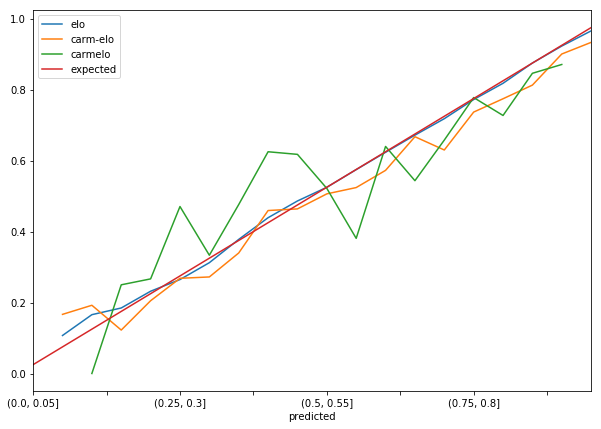

In [7]:
df_compare.plot(x='predicted', figsize=(10,7))